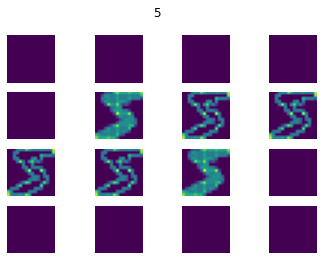

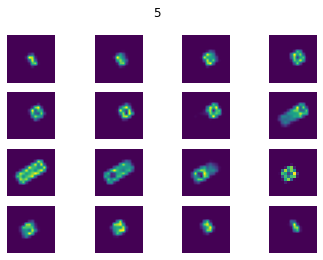

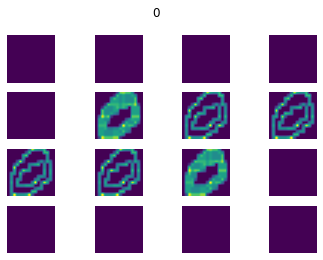

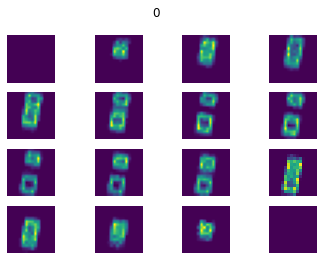

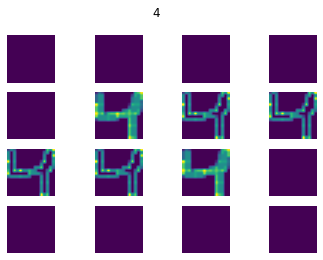

In [1]:
import h5py
import os
import matplotlib.pyplot as plt
import numpy as np

data_path = os.path.join(os.path.expanduser('~'), 'data', '3d-mnist', 
                         'full_dataset_vectors.h5')

assert os.path.isfile(data_path), \
    'Download the 3d-mnist data from https://www.kaggle.com/daavoo/3d-mnist'

with h5py.File(data_path, 'r') as f:
    train_X = np.reshape(f["X_train"][:], (-1, 16, 16, 16, 1))
    train_y = f["y_train"][:]    
    test_X = np.reshape(f["X_test"][:]  , (-1, 16, 16, 16, 1))
    test_y = f["y_test"][:]

train_X = train_X[:,::-1,:,:]
test_X = test_X[:,::-1,:,:]

def onehot(values: np.ndarray) -> np.ndarray:
    encoded = np.zeros((len(values), 10))

    for i in range(len(values)):
        encoded[i,values[i]] = 1

    return encoded

train_y = onehot(train_y)
test_y = onehot(test_y)

for i in range(5):
    fig, ax = plt.subplots(4, 4)
    fig.suptitle(str(np.argmax(train_y[i])))
    ax = ax.ravel()

    for j in range(16):
        ax[j].imshow(train_X[i,:,:,j])
        ax[j].axis('off')

    plt.show()

In [2]:
from tensorflow.keras import Model
from tensorflow.keras.layers import Activation, BatchNormalization, Conv3D, Dense, \
                                    Dropout, Flatten, \
                                    GlobalAveragePooling3D, Input, \
                                    MaxPooling3D
from tensorflow.keras.regularizers import l2

inputs = Input((16, 16, 16, 1), name='inputs')

x = inputs

kernel = (3, 3, 3)
dropout = 0.3
weight_decay = 1e-3
regularizer = l2(weight_decay)

x = Conv3D(32, kernel, padding='SAME', activation=None, 
           kernel_regularizer=regularizer, name='conv1')(x)
x = BatchNormalization(name='norm1')(x)
x = Activation('relu')(x)
x = Conv3D(32, kernel, padding='SAME', activation=None, 
           kernel_regularizer=regularizer, name='conv2')(x)
x = BatchNormalization(name='norm2')(x)
x = Activation('relu')(x)
x = MaxPooling3D((2, 2, 2), name='pool1')(x)
x = Conv3D(64, kernel, padding='SAME', activation=None, 
           kernel_regularizer=regularizer, name='conv3')(x)
x = BatchNormalization(name='norm3')(x)
x = Activation('relu')(x)
x = Conv3D(64, kernel, padding='SAME', activation=None, 
           kernel_regularizer=regularizer, name='conv4')(x)
x = BatchNormalization(name='norm4')(x)
x = Activation('relu')(x)
x = MaxPooling3D((2, 2, 2), name='pool2')(x)
x = Conv3D(128, kernel, padding='SAME', activation=None, 
           kernel_regularizer=regularizer, name='conv5')(x)
x = BatchNormalization(name='norm5')(x)
x = Activation('relu')(x)
x = Conv3D(128, kernel, padding='SAME', activation=None, 
           kernel_regularizer=regularizer, name='conv6')(x)
x = BatchNormalization(name='norm6')(x)
x = MaxPooling3D((2, 2, 2), name='pool3')(x)
x = Conv3D(256, kernel, padding='SAME', activation=None, 
           kernel_regularizer=regularizer, name='conv7')(x)
x = BatchNormalization(name='norm7')(x)
x = Activation('relu')(x)
x = Conv3D(256, kernel, padding='SAME', activation=None, 
           kernel_regularizer=regularizer, name='conv8')(x)
x = BatchNormalization(name='norm8')(x)
x = Activation('relu')(x)
x = GlobalAveragePooling3D(name='pool4')(x)
x = Dropout(dropout)(x)
x = Dense(10, kernel_regularizer=regularizer, activation=None, name='dense')(x)
x = BatchNormalization(name='norm9')(x)
x = Activation('relu')(x)
x = Dropout(dropout)(x)
x = Dense(10, activation='softmax', name='preds')(x)

model = Model(inputs, x)
model.summary()


Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inputs (InputLayer)          [(None, 16, 16, 16, 1)]   0         
_________________________________________________________________
conv1 (Conv3D)               (None, 16, 16, 16, 32)    896       
_________________________________________________________________
norm1 (BatchNormalization)   (None, 16, 16, 16, 32)    128       
_________________________________________________________________
activation (Activation)      (None, 16, 16, 16, 32)    0         
_________________________________________________________________
conv2 (Conv3D)               (None, 16, 16, 16, 32)    27680     
_________________________________________________________________
norm2 (BatchNormalization)   (None, 16, 16, 16, 32)    128       
_________________________________________________________________
activation_1 (Activation)    (None, 16, 16, 16, 32)    0     

2022-03-11 22:57:20.732352: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-03-11 22:57:20.738425: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-03-11 22:57:20.738609: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-03-11 22:57:20.739302: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags

In [3]:
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam

model.compile(loss='categorical_crossentropy', optimizer=Adam(1e-3),
              metrics=['accuracy'])

callbacks = [
    ReduceLROnPlateau(
        monitor="loss",
        factor=0.1,
        patience=5,
        verbose=1
    )
]

model.fit(train_X, train_y, 
          validation_data=(test_X, test_y), 
          epochs=100, 
          batch_size=32, 
          shuffle=True,
          callbacks=callbacks)

2022-03-11 22:57:21.850329: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/100


2022-03-11 22:57:23.293382: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8100
2022-03-11 22:57:23.478975: W tensorflow/stream_executor/gpu/asm_compiler.cc:113] *** WARNING *** You are using ptxas 9.1.108, which is older than 9.2.88. ptxas 9.x before 9.2.88 is known to miscompile XLA code, leading to incorrect results or invalid-address errors.

You do not need to update to CUDA 9.2.88; cherry-picking the ptxas binary is sufficient.


313/313 [==============================] - 9s 22ms/step - loss: 2.5548 - accuracy: 0.3091 - val_loss: 2.6589 - val_accuracy: 0.1370
Epoch 2/100
313/313 [==============================] - 7s 21ms/step - loss: 1.9218 - accuracy: 0.4497 - val_loss: 1.9460 - val_accuracy: 0.4365
Epoch 3/100
313/313 [==============================] - 7s 21ms/step - loss: 1.7455 - accuracy: 0.4918 - val_loss: 1.6515 - val_accuracy: 0.5390
Epoch 4/100
313/313 [==============================] - 7s 21ms/step - loss: 1.6661 - accuracy: 0.5207 - val_loss: 1.7020 - val_accuracy: 0.5135
Epoch 5/100
313/313 [==============================] - 7s 21ms/step - loss: 1.6229 - accuracy: 0.5434 - val_loss: 1.4203 - val_accuracy: 0.6000
Epoch 6/100
313/313 [==============================] - 7s 21ms/step - loss: 1.6002 - accuracy: 0.5443 - val_loss: 1.4446 - val_accuracy: 0.6275
Epoch 7/100
313/313 [==============================] - 7s 21ms/step - loss: 1.5684 - accuracy: 0.5616 - val_loss: 1.5395 - val_accuracy: 0.6045
Epoc

313/313 [==============================] - 7s 22ms/step - loss: 0.8783 - accuracy: 0.8477 - val_loss: 1.2981 - val_accuracy: 0.7815
Epoch 58/100
313/313 [==============================] - 7s 22ms/step - loss: 0.8506 - accuracy: 0.8565 - val_loss: 1.2084 - val_accuracy: 0.7880
Epoch 59/100
313/313 [==============================] - 7s 22ms/step - loss: 0.8724 - accuracy: 0.8460 - val_loss: 1.1275 - val_accuracy: 0.8135
Epoch 60/100
313/313 [==============================] - 7s 22ms/step - loss: 0.8761 - accuracy: 0.8477 - val_loss: 1.2029 - val_accuracy: 0.7865
Epoch 61/100
313/313 [==============================] - 7s 23ms/step - loss: 0.8531 - accuracy: 0.8554 - val_loss: 1.5074 - val_accuracy: 0.7495
Epoch 62/100
313/313 [==============================] - 7s 22ms/step - loss: 0.8550 - accuracy: 0.8563 - val_loss: 1.2710 - val_accuracy: 0.7850
Epoch 63/100
313/313 [==============================] - 7s 22ms/step - loss: 0.8679 - accuracy: 0.8524 - val_loss: 1.2400 - val_accuracy: 0.782

In [9]:
from explainability import LayerwiseRelevancePropagator

image_idx = 0

explanations = np.zeros((10, 16, 16, 16, 1))
predictions = model.predict(train_X[image_idx:image_idx + 1])
print(f'Predictions: {predictions[0]}')

for i in range(10):
    explainer = LayerwiseRelevancePropagator(model, layer=33, idx=i, alpha=2, beta=1)
    explanations[i] = explainer(train_X[image_idx:image_idx + 1])
    print(f'Sum evidence for {i}: {np.sum(explanations[i])}')

Predictions: [3.7237876e-07 3.3463430e-12 2.6286816e-07 5.4158689e-04 7.1555150e-05
 9.9931931e-01 1.3375957e-09 6.6551875e-05 1.5634157e-07 1.2488958e-07]
Sum evidence for 0: 0.011762286908378883
Sum evidence for 1: 9.96565982895603e-08
Sum evidence for 2: 0.008166459038193352
Sum evidence for 3: 16.482925444841385
Sum evidence for 4: 2.2267724369303323
Sum evidence for 5: 61928.61592292786
Sum evidence for 6: 4.205772838261623e-05
Sum evidence for 7: 2.064127550285775
Sum evidence for 8: 0.004766806637007903
Sum evidence for 9: 0.0038605602554753204


In [10]:
model.save_weights('/home/esten/tmp_weights.hdf5')

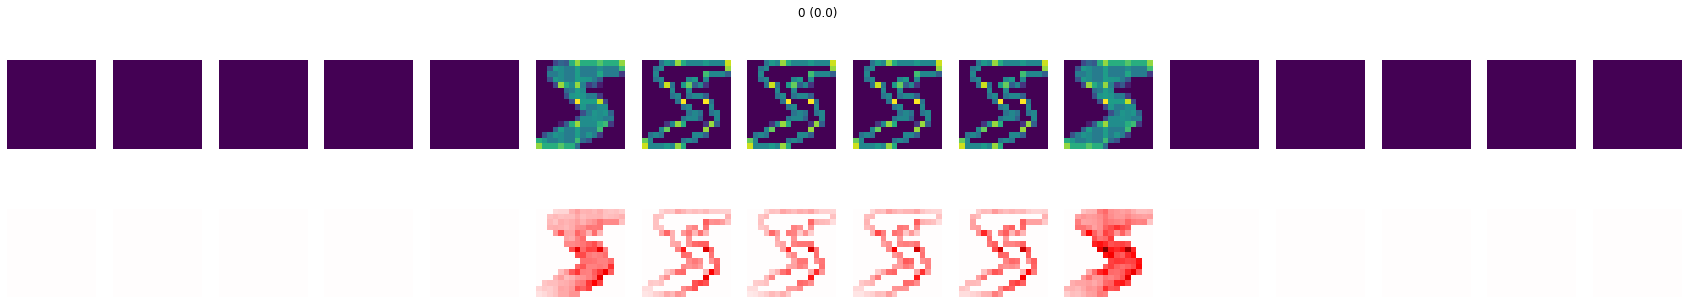

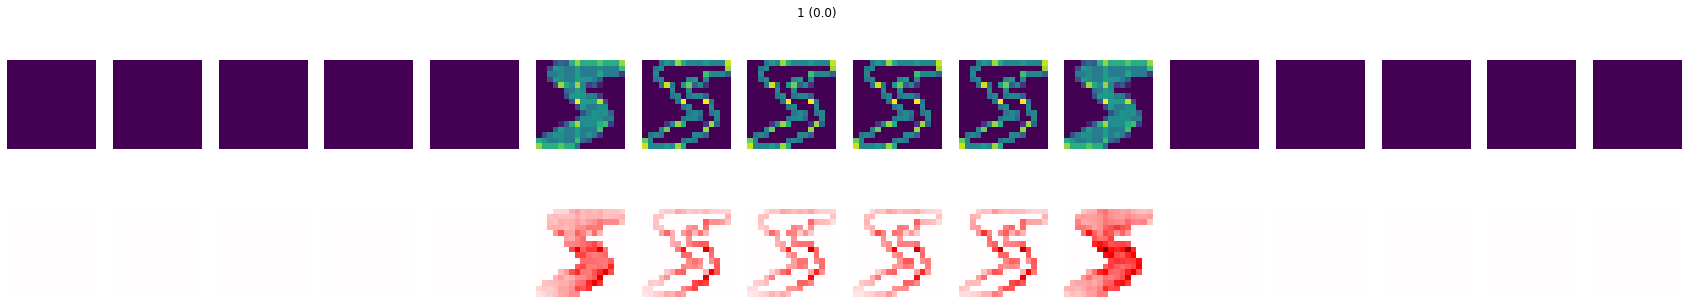

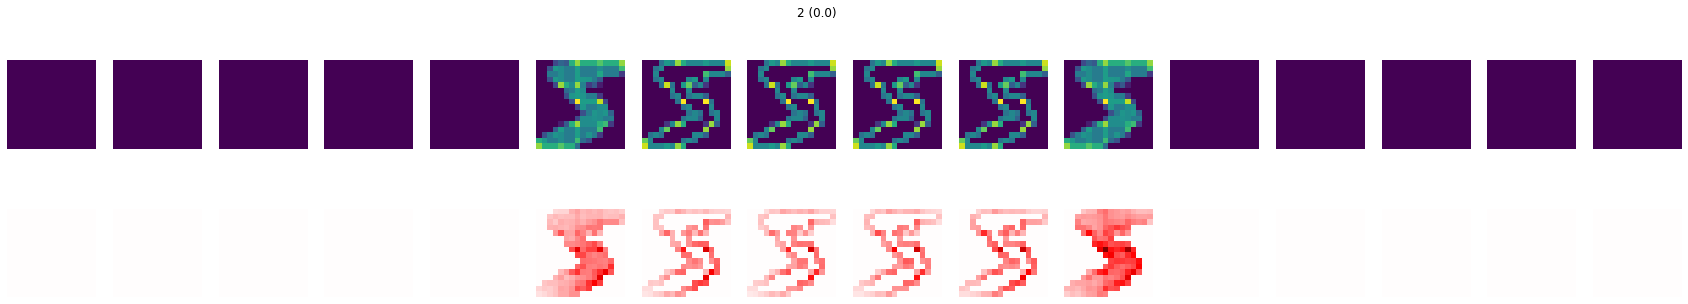

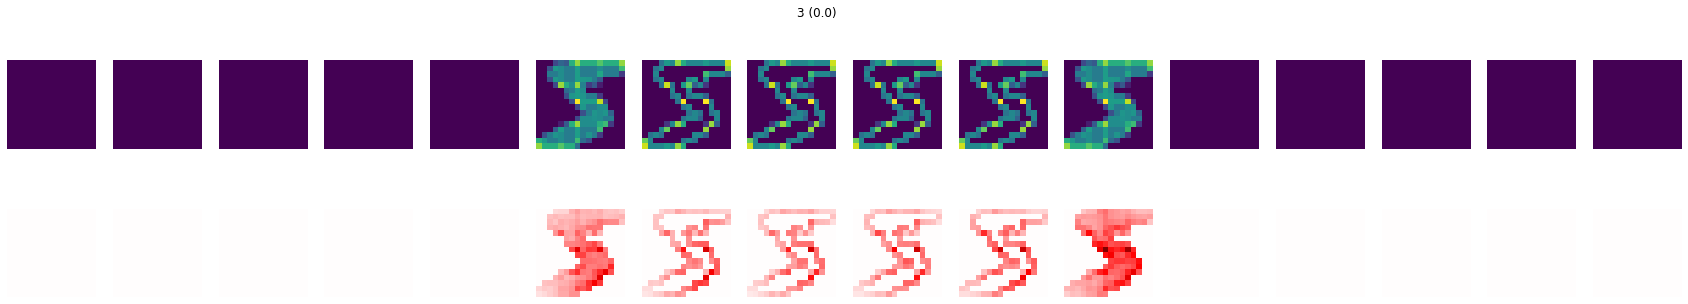

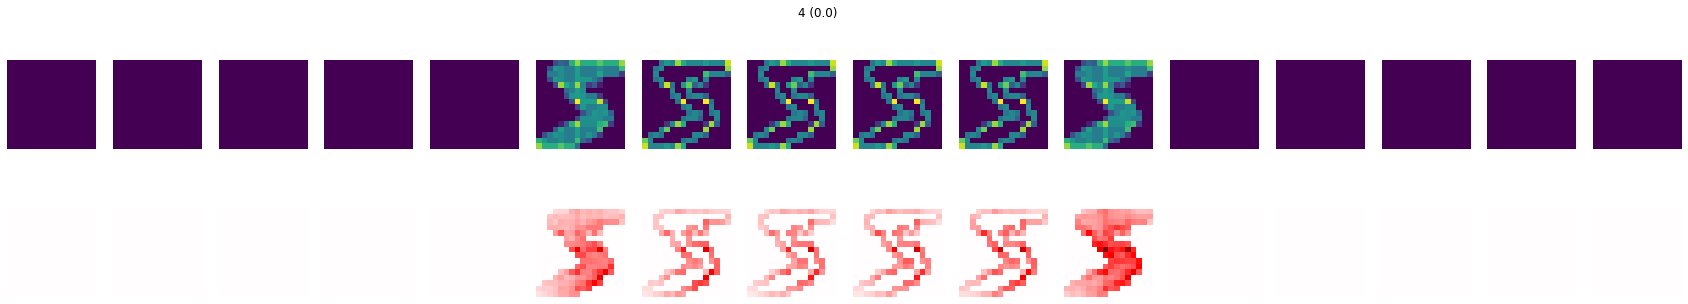

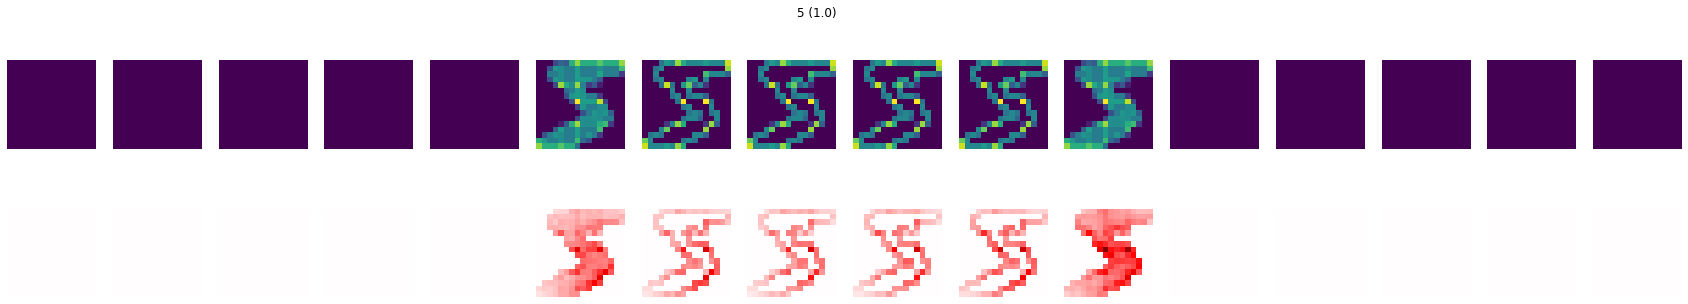

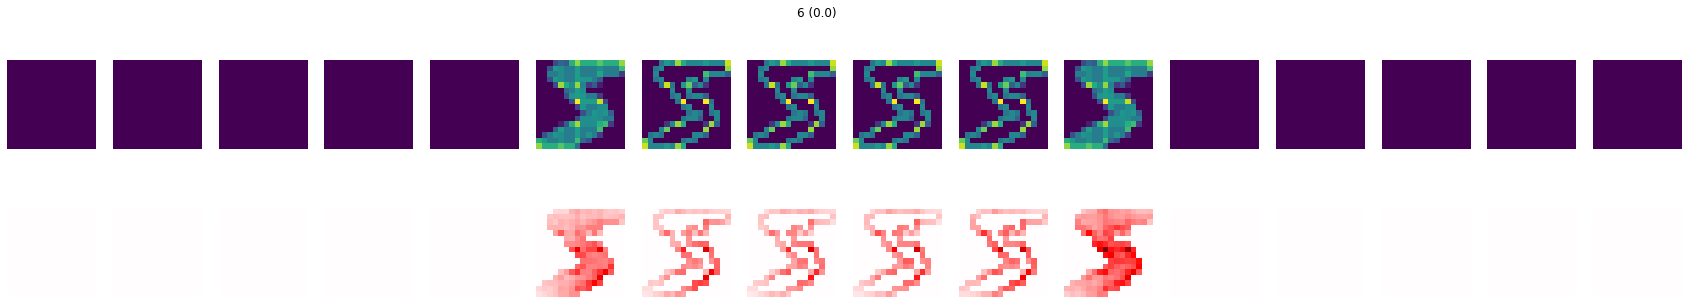

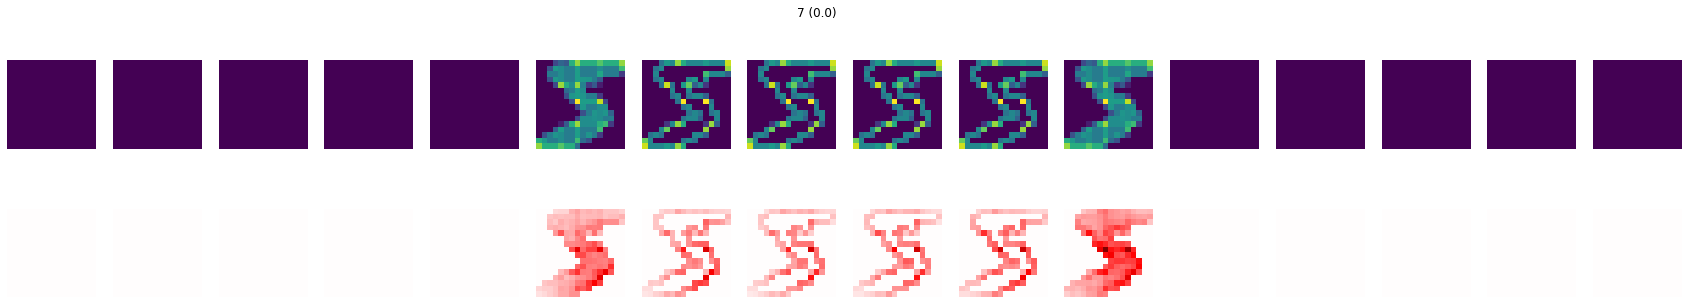

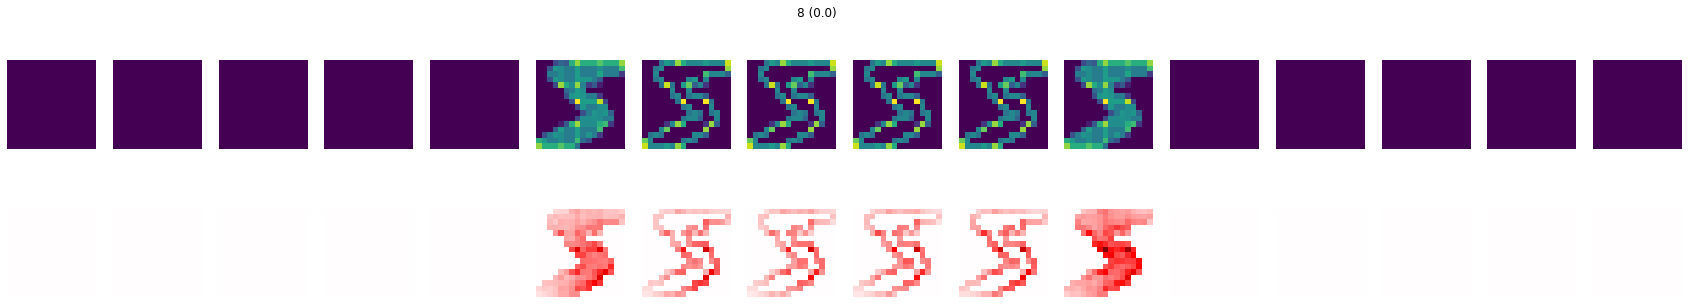

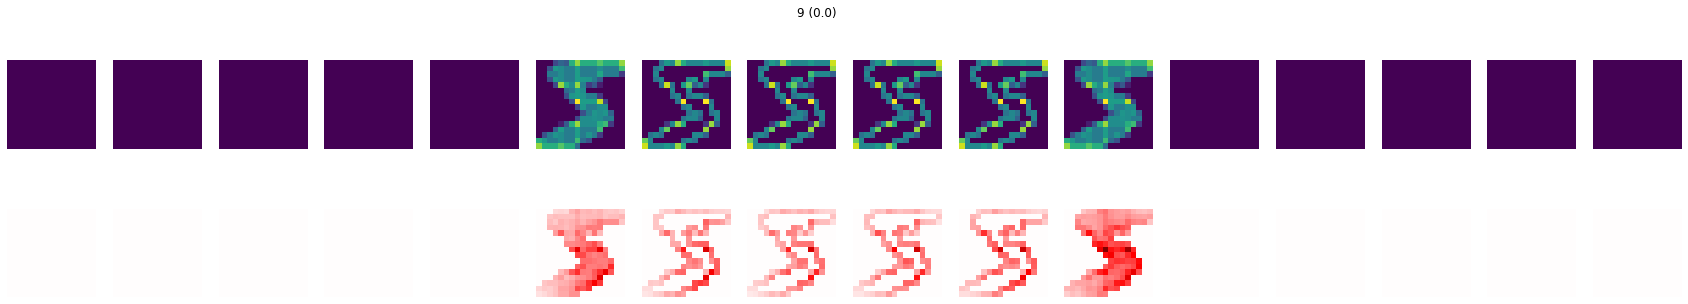

In [11]:
for i in range(len(explanations)):
    explanations[i] = (explanations[i] - np.amin(explanations[i])) / np.amax(explanations[i])
    explanations[i] -= explanations[i,0,0,0,0]
    
    fig, ax = plt.subplots(2, 16, figsize=(30, 5))
    fig.suptitle(f'{i} ({round(predictions[0,i], 2)})')
    
    for j in range(16):
        ax[0][j].imshow(train_X[image_idx,:,:,j])
        ax[1][j].imshow(explanations[i,:,:,j], cmap='seismic', clim=(-1, 1))
        ax[0][j].axis('off')
        ax[1][j].axis('off')
        
    plt.show()

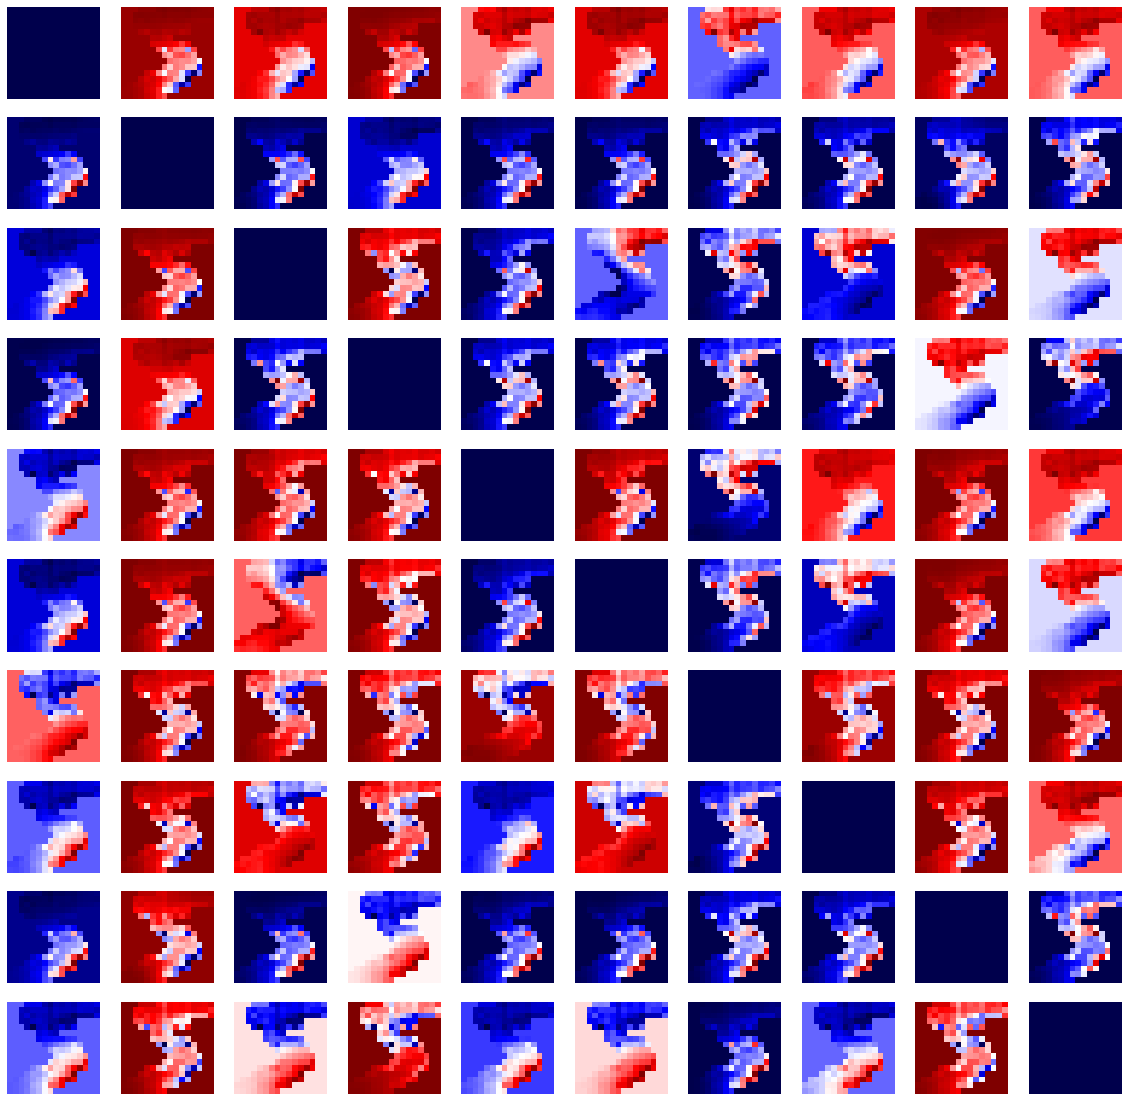

In [12]:
fig, ax = plt.subplots(10, 10, figsize=(20, 20))

for i in range(10):
    for j in range(10):
        ax[i][j].axis('off')
        ax[i][j].imshow(explanations[i,:,:,5] - explanations[j,:,:,5], cmap='seismic')
        
plt.show()

In [13]:
layers = [
    (33, 'prediction'),
    (35, 'mask'),
    (36, 'dense')
]

#for i in range(len(explainer.layers)):
#    print(f'{i}: {explainer.layers[i]}')

for layer, description in layers:
    layerwise_explanations = []
    for i in range(1):
        explainer = LayerwiseRelevancePropagator(model, layer=33, idx=i, alpha=1, beta=0)
        layerwise_explanations.append(explainer(train_X[image_idx:]))
        
    print(layerwise_explanations[0].shape)

2022-03-11 23:11:00.764319: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 327680000 exceeds 10% of free system memory.
2022-03-11 23:11:00.979159: W tensorflow/core/kernels/gpu_utils.cc:49] Failed to allocate memory for convolution redzone checking; skipping this check. This is benign and only means that we won't check cudnn for out-of-bounds reads and writes. This message will only be printed once.
2022-03-11 23:11:11.068557: W tensorflow/core/common_runtime/bfc_allocator.cc:457] Allocator (GPU_0_bfc) ran out of memory trying to allocate 4.88GiB (rounded to 5242880000)requested by op Relu
If the cause is memory fragmentation maybe the environment variable 'TF_GPU_ALLOCATOR=cuda_malloc_async' will improve the situation. 
Current allocation summary follows.
Current allocation summary follows.
2022-03-11 23:11:11.068643: I tensorflow/core/common_runtime/bfc_allocator.cc:1004] BFCAllocator dump for GPU_0_bfc
2022-03-11 23:11:11.068685: I tensorflow/core/common_runtim

ResourceExhaustedError: OOM when allocating tensor with shape[10000,16,16,16,32] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc [Op:Relu]